# RPCの分析

In [1]:
import re
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pprint import pprint
import json
from datasets import load_dataset
from pycirclize import Circos
import japanize_matplotlib

## データセットのダウンロード

In [2]:
dialogue_dataset = load_dataset(
        "nu-dialogue/real-persona-chat",
        name="dialogue",
        trust_remote_code=True
)
interlocutor_dataset = load_dataset(
        "nu-dialogue/real-persona-chat",
        name="interlocutor",
        trust_remote_code=True
)

In [3]:
# 実際のデータセットの中身を確認
print(dialogue_dataset)
print(interlocutor_dataset)

DatasetDict({
    train: Dataset({
        features: ['dialogue_id', 'interlocutors', 'utterances', 'evaluations'],
        num_rows: 13583
    })
})
DatasetDict({
    train: Dataset({
        features: ['interlocutor_id', 'persona', 'personality', 'demographic_information', 'text_chat_experience'],
        num_rows: 233
    })
})


## 各話者ごとにどのぐらいの対話があるのか

In [4]:
# 対話における話者のIDを取得
interlocutor_pair_ids = dialogue_dataset['train']['interlocutors']

# 話者ごとにどのくらいの対話があるかをカウント
interlocutor_dialogue_count = {}
for interlocutor_pair in interlocutor_pair_ids:
    for interlocutor_id in interlocutor_pair:
        if interlocutor_id in interlocutor_dialogue_count:
            interlocutor_dialogue_count[interlocutor_id] += 1
        else:
            interlocutor_dialogue_count[interlocutor_id] = 1

pprint(interlocutor_dialogue_count)

{'AA': 195,
 'AB': 192,
 'AC': 189,
 'AD': 199,
 'AE': 98,
 'AF': 199,
 'AG': 193,
 'AH': 194,
 'AI': 186,
 'AJ': 183,
 'AK': 196,
 'AL': 172,
 'AM': 15,
 'AN': 199,
 'AO': 181,
 'AP': 20,
 'AQ': 191,
 'AR': 100,
 'AS': 177,
 'AT': 200,
 'AU': 194,
 'AV': 195,
 'AW': 191,
 'AX': 183,
 'AY': 199,
 'AZ': 155,
 'BA': 192,
 'BB': 195,
 'BC': 54,
 'BD': 15,
 'BE': 89,
 'BF': 193,
 'BG': 193,
 'BH': 190,
 'BI': 194,
 'BJ': 157,
 'BK': 46,
 'BL': 192,
 'BM': 195,
 'BN': 43,
 'BO': 200,
 'BP': 198,
 'BQ': 185,
 'BR': 189,
 'BS': 197,
 'BT': 190,
 'BU': 184,
 'BV': 197,
 'BW': 190,
 'BX': 189,
 'BY': 197,
 'BZ': 198,
 'CA': 198,
 'CB': 194,
 'CC': 116,
 'CD': 185,
 'CE': 199,
 'CF': 196,
 'CG': 15,
 'CH': 185,
 'CI': 189,
 'CJ': 181,
 'CK': 172,
 'CL': 194,
 'CM': 195,
 'CN': 178,
 'CO': 189,
 'CP': 203,
 'CQ': 94,
 'CR': 192,
 'CS': 135,
 'CT': 198,
 'CU': 198,
 'CV': 197,
 'CW': 10,
 'CX': 197,
 'CY': 197,
 'CZ': 198,
 'DA': 198,
 'DB': 127,
 'DC': 183,
 'DD': 140,
 'DE': 196,
 'DF': 197,
 'D

In [5]:
# 対話数が多い順にソート
sorted_interlocutor_dialogue_count = sorted(interlocutor_dialogue_count.items(), key=lambda x:x[1], reverse=True)
pprint(sorted_interlocutor_dialogue_count)

[('CP', 203),
 ('AT', 200),
 ('BO', 200),
 ('EW', 200),
 ('FR', 200),
 ('FZ', 200),
 ('AD', 199),
 ('AF', 199),
 ('AN', 199),
 ('AY', 199),
 ('CE', 199),
 ('DL', 199),
 ('DV', 199),
 ('FA', 199),
 ('FK', 199),
 ('FL', 199),
 ('GI', 199),
 ('BP', 198),
 ('BZ', 198),
 ('CA', 198),
 ('CT', 198),
 ('CU', 198),
 ('CZ', 198),
 ('DA', 198),
 ('EJ', 198),
 ('FQ', 198),
 ('BS', 197),
 ('BV', 197),
 ('BY', 197),
 ('CV', 197),
 ('CX', 197),
 ('CY', 197),
 ('DF', 197),
 ('DT', 197),
 ('AK', 196),
 ('CF', 196),
 ('DE', 196),
 ('EF', 196),
 ('AA', 195),
 ('AV', 195),
 ('BB', 195),
 ('BM', 195),
 ('CM', 195),
 ('DK', 195),
 ('FO', 195),
 ('GN', 195),
 ('AH', 194),
 ('AU', 194),
 ('BI', 194),
 ('CB', 194),
 ('CL', 194),
 ('DN', 194),
 ('EN', 194),
 ('FF', 194),
 ('FU', 194),
 ('FV', 194),
 ('AG', 193),
 ('BF', 193),
 ('BG', 193),
 ('EM', 193),
 ('AB', 192),
 ('BA', 192),
 ('BL', 192),
 ('CR', 192),
 ('EK', 192),
 ('EO', 192),
 ('EZ', 192),
 ('AQ', 191),
 ('AW', 191),
 ('ED', 191),
 ('GG', 191),
 ('BH'

In [6]:
# 対話数が200以上の話者の人数と190以上200未満の話者の人数をカウント
count_200 = 0
count_190 = 0
for interlocutor_id, dialogue_count in sorted_interlocutor_dialogue_count:
    if dialogue_count >= 200:
        count_200 += 1
    elif dialogue_count >= 190:
        count_190 += 1

print(count_200)
print(count_190)

6
68


In [7]:
# 対話数が190以上の話者を(ID, 対話数)の形で取得
interlocutor_dialogue_count_190 = {interlocutor_id: dialogue_count for interlocutor_id, dialogue_count in sorted_interlocutor_dialogue_count if dialogue_count >= 190}
# 対話数でソート
sorted_interlocutor_dialogue_count_190 = sorted(interlocutor_dialogue_count_190.items(), key=lambda x:x[1], reverse=True)
pprint(sorted_interlocutor_dialogue_count_190)

[('CP', 203),
 ('AT', 200),
 ('BO', 200),
 ('EW', 200),
 ('FR', 200),
 ('FZ', 200),
 ('AD', 199),
 ('AF', 199),
 ('AN', 199),
 ('AY', 199),
 ('CE', 199),
 ('DL', 199),
 ('DV', 199),
 ('FA', 199),
 ('FK', 199),
 ('FL', 199),
 ('GI', 199),
 ('BP', 198),
 ('BZ', 198),
 ('CA', 198),
 ('CT', 198),
 ('CU', 198),
 ('CZ', 198),
 ('DA', 198),
 ('EJ', 198),
 ('FQ', 198),
 ('BS', 197),
 ('BV', 197),
 ('BY', 197),
 ('CV', 197),
 ('CX', 197),
 ('CY', 197),
 ('DF', 197),
 ('DT', 197),
 ('AK', 196),
 ('CF', 196),
 ('DE', 196),
 ('EF', 196),
 ('AA', 195),
 ('AV', 195),
 ('BB', 195),
 ('BM', 195),
 ('CM', 195),
 ('DK', 195),
 ('FO', 195),
 ('GN', 195),
 ('AH', 194),
 ('AU', 194),
 ('BI', 194),
 ('CB', 194),
 ('CL', 194),
 ('DN', 194),
 ('EN', 194),
 ('FF', 194),
 ('FU', 194),
 ('FV', 194),
 ('AG', 193),
 ('BF', 193),
 ('BG', 193),
 ('EM', 193),
 ('AB', 192),
 ('BA', 192),
 ('BL', 192),
 ('CR', 192),
 ('EK', 192),
 ('EO', 192),
 ('EZ', 192),
 ('AQ', 191),
 ('AW', 191),
 ('ED', 191),
 ('GG', 191),
 ('BH'

In [8]:
print(len(sorted_interlocutor_dialogue_count_190))

74


## 190対話以上の話者のビッグファイブ特性を分析

In [9]:
more_than_190_interlocutor_dialogue_count = sorted_interlocutor_dialogue_count[:len(sorted_interlocutor_dialogue_count_190)]
pprint(more_than_190_interlocutor_dialogue_count)

[('CP', 203),
 ('AT', 200),
 ('BO', 200),
 ('EW', 200),
 ('FR', 200),
 ('FZ', 200),
 ('AD', 199),
 ('AF', 199),
 ('AN', 199),
 ('AY', 199),
 ('CE', 199),
 ('DL', 199),
 ('DV', 199),
 ('FA', 199),
 ('FK', 199),
 ('FL', 199),
 ('GI', 199),
 ('BP', 198),
 ('BZ', 198),
 ('CA', 198),
 ('CT', 198),
 ('CU', 198),
 ('CZ', 198),
 ('DA', 198),
 ('EJ', 198),
 ('FQ', 198),
 ('BS', 197),
 ('BV', 197),
 ('BY', 197),
 ('CV', 197),
 ('CX', 197),
 ('CY', 197),
 ('DF', 197),
 ('DT', 197),
 ('AK', 196),
 ('CF', 196),
 ('DE', 196),
 ('EF', 196),
 ('AA', 195),
 ('AV', 195),
 ('BB', 195),
 ('BM', 195),
 ('CM', 195),
 ('DK', 195),
 ('FO', 195),
 ('GN', 195),
 ('AH', 194),
 ('AU', 194),
 ('BI', 194),
 ('CB', 194),
 ('CL', 194),
 ('DN', 194),
 ('EN', 194),
 ('FF', 194),
 ('FU', 194),
 ('FV', 194),
 ('AG', 193),
 ('BF', 193),
 ('BG', 193),
 ('EM', 193),
 ('AB', 192),
 ('BA', 192),
 ('BL', 192),
 ('CR', 192),
 ('EK', 192),
 ('EO', 192),
 ('EZ', 192),
 ('AQ', 191),
 ('AW', 191),
 ('ED', 191),
 ('GG', 191),
 ('BH'

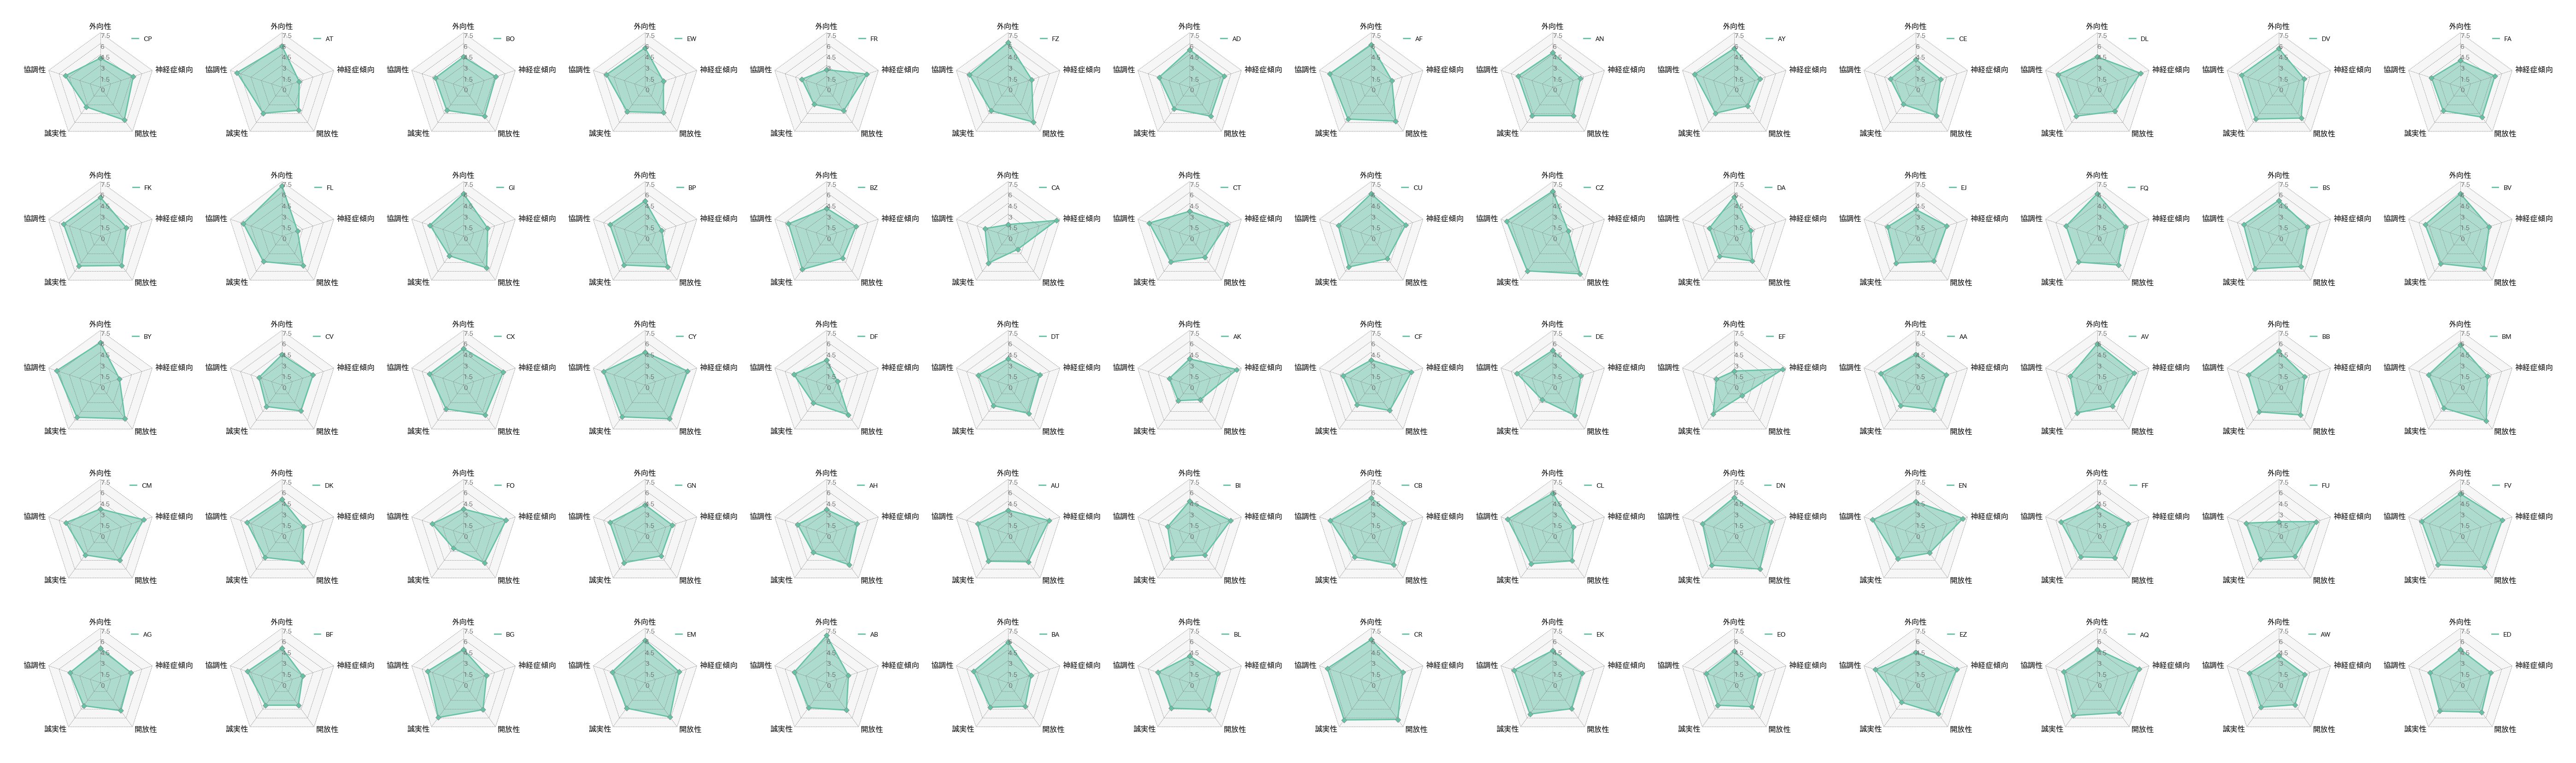

In [11]:
class BigFivePersonality:
    def __init__(self, openness: int, conscientiousness: int, extraversion: int, agreeableness: int, neuroticism: int):
        self.openness = openness
        self.conscientiousness = conscientiousness
        self.extraversion = extraversion
        self.agreeableness = agreeableness
        self.neuroticism = neuroticism

class Interlocutor:
    def __init__(self, id: str, personality: BigFivePersonality):
        self.id = id
        self.personality = personality
    def get_personality(self):
        # 外向性, 神経症傾向, 開放性, 誠実性, 協調性の順
        return [
            self.personality.extraversion,
            self.personality.neuroticism,
            self.personality.openness,
            self.personality.conscientiousness,
            self.personality.agreeableness
        ]

more_than_190_interlocutors = []
# 上位20人のビッグファイブを取得
for interlocutor in more_than_190_interlocutor_dialogue_count:
    interlocutor_id = interlocutor[0]
    for interlocutor_data in interlocutor_dataset['train']:
        if interlocutor_data['interlocutor_id'] == interlocutor_id:
            personality = BigFivePersonality(
                interlocutor_data['personality']['BigFive_Openness'],
                interlocutor_data['personality']['BigFive_Conscientiousness'],
                interlocutor_data['personality']['BigFive_Extraversion'],
                interlocutor_data['personality']['BigFive_Agreeableness'],
                interlocutor_data['personality']['BigFive_Neuroticism']
            )
            interlocutor = Interlocutor(interlocutor_id, personality)
            more_than_190_interlocutors.append(interlocutor)
            break

# 上位10人のビッグファイブをレーダーチャートで可視化
big_five_column = ["外向性", "神経症傾向", "開放性", "誠実性", "協調性"]
more_than_190_interlocutor_ids = [interlocutor.id for interlocutor in more_than_190_interlocutors]
more_than_190_interlocutor_personalities = [interlocutor.get_personality() for interlocutor in more_than_190_interlocutors]

df = pd.DataFrame(
    data=more_than_190_interlocutor_personalities,
    columns=big_five_column,
    index=more_than_190_interlocutor_ids
)


fig = plt.figure(figsize=(70, 20))
fig.subplots(5, 14, subplot_kw=dict(polar=True))
fig.subplots_adjust(hspace=0.3, wspace=0.3)

for id, ax in zip(more_than_190_interlocutor_ids, fig.axes):
    circos = Circos.radar_chart(
        df.loc[[id]],
        vmax=7.5,
        marker_size=6,
        grid_interval_ratio=0.2,
        line_kws_handler=lambda _: dict(lw=2, ls="solid"),
        marker_kws_handler=lambda _: dict(marker="D", ec="grey", lw=0.5),
    )
    
    circos.plotfig(ax=ax)
    circos.ax.legend(loc="upper right", fontsize=10)

fig.savefig("image/more_than_190_interlocutor_big_five.png")

## 対話数が一番多い話者の対話内容の分析 (idがCPの話者)

In [9]:
interlocutor_id = 'CP'

CP_dialogues = []
for dialogue_data in dialogue_dataset['train']:
    if interlocutor_id in dialogue_data['interlocutors']:
        CP_dialogues.append(dialogue_data)

pprint(CP_dialogues[0])

{'dialogue_id': 941,
 'evaluations': {'comprehension': [3, 5],
                 'familiarity': [5, 5],
                 'informativeness': [4, 5],
                 'interest': [3, 5],
                 'interlocutor_id': ['CA', 'CP'],
                 'proactiveness': [3, 4],
                 'satisfaction': [3, 5]},
 'interlocutors': ['CA', 'CP'],
 'utterances': {'interlocutor_id': ['CA',
                                    'CP',
                                    'CA',
                                    'CP',
                                    'CA',
                                    'CP',
                                    'CA',
                                    'CP',
                                    'CA',
                                    'CP',
                                    'CA',
                                    'CP',
                                    'CA',
                                    'CP',
                                    'CA',
                    

In [14]:
'''
CP_dialoguesのそれぞれのデータを以下のjson形式に変換
{
    dialogue_id: int,
    interlocutors: [str, str],
    utterances: [
        {
            utterance_id: int,
            interlocutor_id: str,
            text: str
        },
        ...
    ],
}
'''

CP_dialogues_json = []
for dialogue_data in CP_dialogues:
    dialogue_json = {
        'dialogue_id': dialogue_data['dialogue_id'],
        'interlocutors': dialogue_data['interlocutors'],
        'utterances': []
    }
    for i, utterance_id in enumerate(dialogue_data['utterances']['utterance_id']):
        utterance = {
            'utterance_id': utterance_id,
            'interlocutor_id': dialogue_data['utterances']['interlocutor_id'][i],
            # テキストに含まれる全角スペース削除
            'text': re.sub('　', '', dialogue_data['utterances']['text'][i])
        }
        dialogue_json['utterances'].append(utterance)
    CP_dialogues_json.append(dialogue_json)

pprint(CP_dialogues_json[0])

{'dialogue_id': 941,
 'interlocutors': ['CA', 'CP'],
 'utterances': [{'interlocutor_id': 'CA',
                 'text': 'こんにちは。はじめまして。<CA>と申します',
                 'utterance_id': 0},
                {'interlocutor_id': 'CP',
                 'text': 'こんにちは。<CP>です。よろしくお願いします。',
                 'utterance_id': 1},
                {'interlocutor_id': 'CA',
                 'text': 'こちらは今日も暑くなりはじめてきましたが、まいさんのところのお天気はどんなでしょう？',
                 'utterance_id': 2},
                {'interlocutor_id': 'CP',
                 'text': '暑くなりつつあります。今日も晴天です！',
                 'utterance_id': 3},
                {'interlocutor_id': 'CA',
                 'text': 'いい日になりそうですね！まだまだ夏日だ',
                 'utterance_id': 4},
                {'interlocutor_id': 'CP',
                 'text': 'ですね。蝉が煩いです。',
                 'utterance_id': 5},
                {'interlocutor_id': 'CA',
                 'text': 'セミ鳴いてるんですね！ミンミンゼミかな？',
                 'utterance_id': 6},
                {'interlocutor_id'

In [15]:
# ダイアログデータをjsonファイルに保存
with open('data/CP_dialogues.json', 'w', encoding='utf-8') as f:
    json.dump(CP_dialogues_json, f, indent=2, ensure_ascii=False)

# ReaLPersonaChatの発話内に「()」が含まれているかどうか確認する
内心描写のフォーマットとして()が使えないかどうか確認したかったから。

In [4]:
# 発話内容に「()」が含まれる発話を抽出
for dialogue in dialogue_dataset['train']:
    for i, utterance in enumerate(dialogue['utterances']['text']):
        if '(' in utterance and ')' in utterance:
            print(dialogue['utterances']['text'][i])

うちの娘(高校2年)が、教えながらびっくりしたらしいので、恐ろしいジェネレーションギャップです。
ALFEE (←わかりますか？)の配信なのですが。
いえ、私は全然作れないのですが(むしろ不器用です、、)、洋服は大好きです！
そうなんですね！　BIGBANGと同じ時期か、少し後くらいにf(x)っていうアイドルがいて好きでした。
私の場合一食一枚(200g)以上食べてます
CDよりLIVEの方が全然いいですね！桜井さん(髭グラサンの人)の声が衰え知らずで鳥肌立ちました。
ちなみに、上記のメニュー+ご飯(お米)とかですか？
‎CathyDoll（キャシードール）かSRICHAND(シーチャン)が有名です。暑い国仕様なので皮脂で崩れにくいです！
